## Context


**Dataset Source** : KAGGLE

**Dataset Content** :
This dataset contains 12,500 augmented images of blood cells (JPEG) with accompanying cell type labels (CSV). There are approximately 2,500 images for each of 4 different cell types grouped into 4 different folders (according to cell type). 

The cell types are Eosinophil, Lymphocyte, Monocyte, and Neutrophil. 

**Inspiration** : Cells Classification with the images provided in the folder 'dataset2-master'


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, cv2, scipy, itertools
from time import time

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.models import Model 
from keras.callbacks import TensorBoard

np.set_printoptions(precision=2)
SEED = np.random.seed(12)
%matplotlib inline

Using TensorFlow backend.


pwd

In [3]:
CURRENT_DIR = os.path.abspath(os.path.dirname("../BCIC/"))
TRAIN_DIR = os.path.abspath(os.path.dirname(CURRENT_DIR + "/dataset2-master/images/TRAIN/*"))
TEST_DIR = os.path.abspath(os.path.dirname(CURRENT_DIR + "/dataset2-master/images/TEST/*"))

## Data Preparation Functions

In [4]:
def load_data(input_dir):
    """
    Load data from train or test directory
    Stochastic gradient algorithm for metric learning
    Parameters
    ----------
    input_dir : string
       Directory where the data are
    Return
    ------       
    df : pandas dataframe
       The dataframe with the numerical labels,
       the categorical labels and the images file name
    dict_categories : int
       The encoded label of each cell type in the list 
       (Eosinophil, Lymphocyte, Monocyte, Neutrophil)
    dict_sub_categories : int
       The encoded label of each cell type in the list 
       (Mononuclear, Polynuclear)
    """
    
    images_dir, images_name = [], [] 
    dict_categories, dict_sub_categories = {}, {}
    
    # Load raw data
    for i, folder in enumerate(os.listdir(input_dir)):
        curr_dir = input_dir + '/' + folder
        if os.path.isdir(curr_dir):
            curr_images_name = [os.path.join(curr_dir, s) for s in os.listdir(curr_dir)]
            images_name.extend(curr_images_name)
            images_dir.extend([folder]*len(curr_images_name))
            dict_categories[i] = folder
        
    df = pd.DataFrame.from_dict({'category1':images_dir, 'category2':images_dir, 'images_name':images_name})

    # Encode the categorical values
    df['category1_le'] = LabelEncoder().fit(df['category1']).transform(df['category1'])
    df.loc[df['category2'].isin(['EOSINOPHIL', 'NEUTROPHIL']), 'category2'] = 0
    df.loc[df['category2'].isin(['LYMPHOCYTE', 'MONOCYTE']), 'category2'] = 1
    dict_sub_categories = {0:'Mononuclear',1:'Polynuclear'}
    return df, dict_categories, dict_sub_categories

def get_label_indices(input_df, label=0, sub_category=None):
    """
    Match each encoded label value to its label name
    """
    if sub_category is None:
        if label in [0, 1, 2, 3]:
            return np.where(input_df.category1_le == label)[0]
    else:
        if label in [0, 1]:
            return np.where(input_df.category2 == label)[0]
    return None

def prepare_data(input_df, new_size):
    """
    Read the images and resize the images
    Parameters
    ----------
    input_df : pandas dataframe
       The dataframe with the numerical labels,
       the categorical labels and the images file name
    new_size : tuple, (height, width, n_channels)
       Images downsampling size. The images should be in rgb. 
       
    Return
    ------       
    X : array, (n_samples, n_features)
       The dataframe with the numerical labels,
       the categorical labels and the images file name
    Y_hot_enc : (n_samples, n_classes=4)
       Each encoded label matching to one of this 
       (Eosinophil, Lymphocyte, Monocyte, and Neutrophil)
       is converted to binary class vector.
       All the labels vector become a matrix

    Z_hot_enc : (n_samples, n_classes=2)
        Each encoded label matching to one of this 
       (Mononuclear, Polynuclear) is converted to binary class vector.
       All the labels vector become a matrix

    """
    X, Y, Z = [], [], []
        
    # Read images - Load data in their container
    for i, each_file in enumerate(input_df['images_name']):
        img = cv2.imread(each_file)
        if img is not None:
            # Downsample the image to new_size
            X.append(scipy.misc.imresize(arr=img, size=new_size))
            Y.append(input_df.loc[i, 'category1_le'])
            Z.append(input_df.loc[i, 'category2'])
    
    X, Y, Z = np.asarray(X), np.asarray(Y), np.asarray(Z)
    Y_hot_enc = to_categorical(Y, num_classes = 4)
    Z_hot_enc = to_categorical(Z, num_classes = 2)
    
    return X, Y_hot_enc, Z_hot_enc

## Display Functions

In [5]:
def plot_gallery(images, dict_labels, nrows=2):
    plt.figure(figsize=(20,6))
    n_labels = len(dict_labels.keys())
    k=1
    for j in range(nrows):
        for each_label in range(n_labels):
            plt.subplot(nrows, n_labels, k )
            r = get_label_indices(input_df=df_train_in, label=each_label, sub_category=None)
            if r is not None:
                plt.imshow(images[r[j]])
                plt.grid(False)
                plt.title(dict_labels[each_label+1], fontsize=14)
                plt.xticks(())
                plt.yticks(())
                k+=1
    plt.show()
        
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
   
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8,8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%.2f %%'%(cm[i, j]*100),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=12)

    plt.tight_layout()
    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_model_history(model_history):
    """
    This function plots accuracy and loss at each epoch.
    """
    plt.figure(figsize=(20, 4))

    n_epochs = len(model_history.history['acc'])
    # display accuracy
    ax = plt.subplot(1, 2 ,1)
    plt.plot(np.arange(n_epochs), model_history.history['acc'], label='acc')
    plt.plot(np.arange(n_epochs), model_history.history['val_acc'],  label='val_acc')
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    plt.title("Accuracy", fontsize=18)
    plt.legend(loc='best', fontsize=14)
    plt.xlabel("epoch", fontsize=14) 
    plt.ylabel("value", fontsize=14)  

    # display loss
    ax = plt.subplot(1, 2 ,2)
    plt.plot(np.arange(n_epochs), model_history.history['loss'], label='loss')
    plt.plot(np.arange(n_epochs), model_history.history['val_loss'], label='val_loss')
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    plt.title("Loss", fontsize=18)
    plt.legend(loc='best', fontsize=14)
    plt.xlabel("epoch", fontsize=14) 
    plt.ylabel("value", fontsize=14) 
    plt.show()

def show_results(model, 
                 history,
                 X_test,
                 y_true_hot_enc,
                 dict_categories
                 ):
    
    y_pred_hot_enc = model.predict(X_test)
    y_true, y_pred = np.argmax(y_true_hot_enc,axis=1), np.argmax(y_pred_hot_enc, axis=1)

    print("----------------------")
    print("Model History")
    print("----------------------")
    plot_model_history(model_history = history)

    print("----------------------")
    results_test = model.evaluate(X_test, y_true_hot_enc)
    print('Loss of Test set %.2f Accuracy of Test set %.2f%%'%(results_test[0], results_test[1]*100))
    print("----------------------")

    print("----------------------")
    print("Classification Report")
    print("----------------------")
    print(classification_report(y_true, y_pred, target_names=dict_categories.values()))

    print("----------------------")
    print("Confusion Matrix")
    print("----------------------")

    cnf_matrix = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plot_confusion_matrix(cnf_matrix, classes=dict_categories.values(), title='Confusion matrix')



# Let's Start

### ** 1 - Load the data **

In [6]:
df_train_in, dict_categories, dict_sub_categories = load_data(input_dir = TRAIN_DIR)
df_test_in, _, _ = load_data(input_dir = TEST_DIR)

### ** 2 - Prepare the data **

In [7]:
IM_SIZE = (60, 80, 3)
X_train, y_train_hot_enc, z_train_hot_enc = prepare_data(input_df=df_train_in, new_size=IM_SIZE)
X_test, y_test_hot_enc, z_test_hot_enc = prepare_data(input_df=df_test_in, new_size=IM_SIZE)

### ** 3 - Display some of them and statistics **

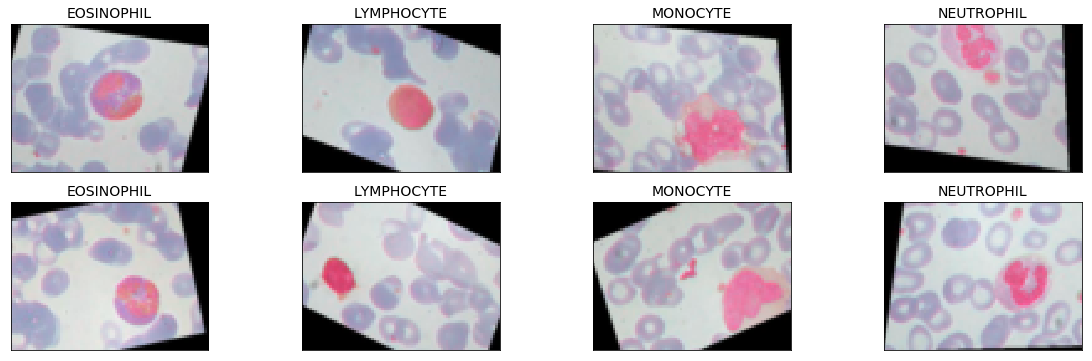

In [8]:
plot_gallery(images=X_train, dict_labels=dict_categories, nrows=2)

Counter({'NEUTROPHIL': 2499, 'EOSINOPHIL': 2497, 'LYMPHOCYTE': 2483, 'MONOCYTE': 2478})


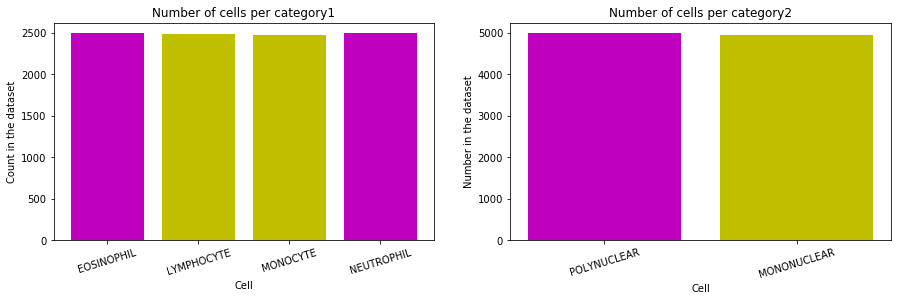

In [9]:
plt.figure(figsize=(15, 4))
D = Counter(df_train_in['category1'])
D2 = Counter(df_train_in['category2'])
print(D)
my_colors = 'myym'  #magenta, yellow, yellow, magenta 

# display category 1
plt.subplot(1, 2, 1)
plt.bar(range(len(D)),  D.values(), color=my_colors)
plt.xticks(np.arange(len(D)), D.keys(), rotation=17)
plt.title("Number of cells per category1")
plt.xlabel("Cell")
plt.ylabel("Count in the dataset")

# display category 2
plt.subplot(1, 2, 2)
plt.bar(range(len(D2)),  D2.values(), color=my_colors)
plt.xticks(np.arange(len(D2)), ['POLYNUCLEAR', 'MONONUCLEAR'], rotation=17)
plt.title("Number of cells per category2")
plt.xlabel("Cell")
plt.ylabel("Number in the dataset")

plt.subplots_adjust()

plt.show()

### ** 4 - Normalize and Split the data **

In [10]:
X_train_p, X_test_p = X_train/255.0, X_test/255.0
X_tr, X_val , y_tr, y_val, z_tr, z_val = train_test_split(X_train_p, y_train_hot_enc, z_train_hot_enc,
                                                          test_size=0.20, random_state=SEED, shuffle=True)

### ** 5 - Build a first CNN model**

#### * Test for a multi-class problem *

In [11]:
%%time
NUM_CLASSES = 4
MAX_EPOCHS = 15
BATCH_SIZE = 64

def my_model(num_classes):
    input_img = Input(shape=(IM_SIZE[0], IM_SIZE[1], 3), name='input_layer')  # adapt this if using `channels_first` image data format

    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv1')(input_img)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv2')(x)
    x = MaxPooling2D((3, 2), padding='same', name='maxp2')(x)       
    x = Dropout(0.3)(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv3')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv4')(x)
    x = MaxPooling2D((2, 2), padding='same', name='encoded')(x)   
    x = Flatten(name='flatten')(x)
    x = Dense(64, activation='relu', name='dense1')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', name='dense2')(x)
    output = Dense(num_classes, activation='softmax', name='classification_layer')(x)

    model = Model(input_img, output)
    return model

model1_1 = my_model(num_classes=NUM_CLASSES)
print(model1_1.summary())

model1_1.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
history1_1 = model1_1.fit(X_tr, y_tr,
                epochs=MAX_EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(X_val, y_val),
                callbacks=[TensorBoard(log_dir=CURRENT_DIR+'/tmp')])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 60, 80, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 60, 80, 16)        448       
_________________________________________________________________
conv2 (Conv2D)               (None, 60, 80, 16)        2320      
_________________________________________________________________
maxp2 (MaxPooling2D)         (None, 20, 40, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 20, 40, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 20, 40, 32)        9248      
__________

#### * Plot and analyse the results *

----------------------
Model History
----------------------


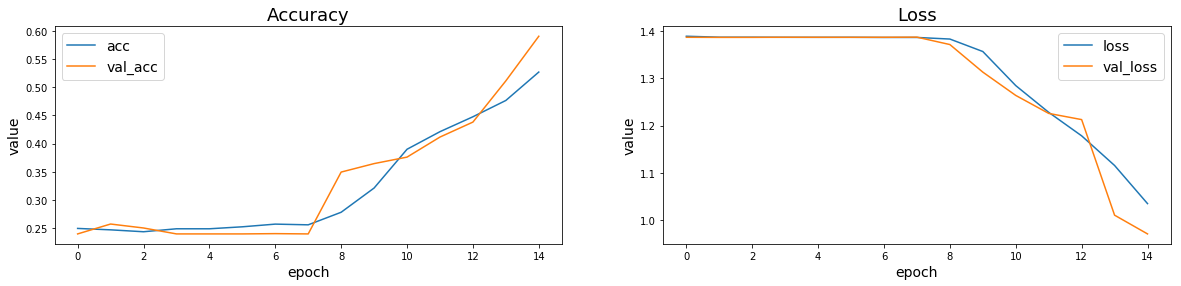

----------------------
2487/2487 [==============================] - 9s     

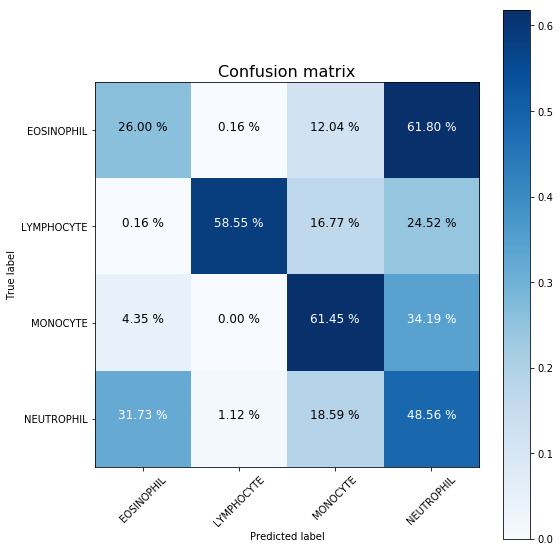

In [12]:
show_results(model=model1_1, 
                 history=history1_1,
                 X_test=X_test,
                 y_true_hot_enc=y_test_hot_enc,
                 dict_categories=dict_categories)

#### * Test for a  multi-label problem (binary classification)*

Only the number of classes and the batch size change

In [13]:
%%time
NUM_CLASSES = 2
BATCH_SIZE = 128
model1_2 = my_model(num_classes=NUM_CLASSES)

model1_2.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
history1_2 = model1_2.fit(X_tr, z_tr,
                epochs=MAX_EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(X_val, z_val),
                callbacks=[TensorBoard(log_dir=CURRENT_DIR+'/tmp')])
model1_2.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

Train on 7965 samples, validate on 1992 samples
Epoch 1/15
7965/7965 [==============================] - 85s - loss: 0.6948 - acc: 0.4905 - val_loss: 0.6931 - val_acc: 0.5115

#### * Plot and analyse the results *

----------------------
Model History
----------------------


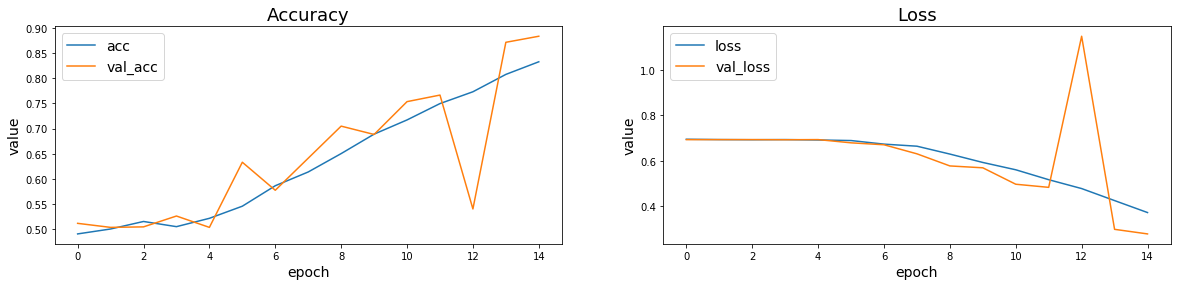

----------------------
2487/2487 [==============================] - 9s      

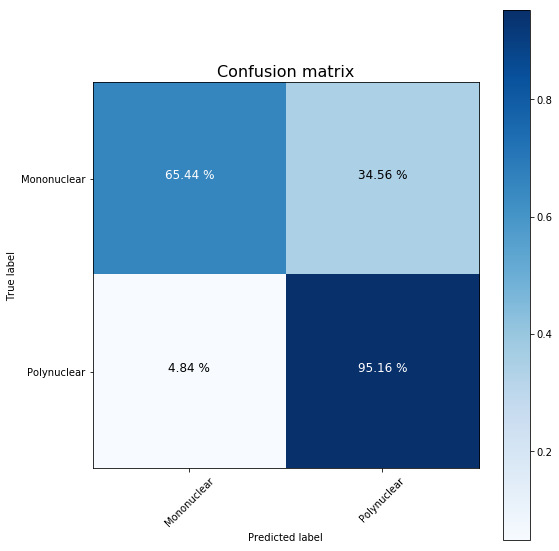

CPU times: user 41.8 s, sys: 7.64 s, total: 49.4 s
Wall time: 20 s


In [14]:
%%time
show_results(model=model1_2, 
                 history=history1_2,
                 X_test=X_test,
                 y_true_hot_enc=z_test_hot_enc,
                 dict_categories=dict_sub_categories)

### ** 6 - Keep trying with the same model as before with more preprocessing on data **

#### * Test for a  multi-label problem (binary classification)*

In [15]:
%%time
from keras.preprocessing.image import ImageDataGenerator

NUM_CLASSES = 2
BATCH_SIZE = 32
MAX_EPOCHS = 10

def my_model2(num_classes):
    input_img = Input(shape=(IM_SIZE[0], IM_SIZE[1], 3), name='input_layer')  # adapt this if using `channels_first` image data format

    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv1')(input_img)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv3')(x)
    x = MaxPooling2D((2, 2), padding='same', name='maxp2')(x)       
    x = Dropout(0.3)(x)
    x = MaxPooling2D((2, 2), padding='same', name='encoded')(x)   
    x = Flatten(name='flatten')(x)
    x = Dense(96, activation='relu', name='dense1')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax', name='classification_layer')(x)

    model = Model(input_img, output)
    return model

model2_1 = my_model2(num_classes=NUM_CLASSES)
print(model2_1.summary())

model2_1.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        shear_range=0.15,
        zoom_range=0.3,
        #rescale=1/255.0,
        vertical_flip=True)  # randomly flip images

history2_1 = model2_1.fit_generator(datagen.flow(X_tr, z_tr, batch_size=BATCH_SIZE, shuffle=True),
                                steps_per_epoch=len(X_tr) / BATCH_SIZE, 
                                epochs=MAX_EPOCHS,
                                validation_data=(X_val, z_val))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     (None, 60, 80, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 60, 80, 32)        896       
_________________________________________________________________
conv3 (Conv2D)               (None, 60, 80, 32)        9248      
_________________________________________________________________
maxp2 (MaxPooling2D)         (None, 30, 40, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 40, 32)        0         
_________________________________________________________________
encoded (MaxPooling2D)       (None, 15, 20, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9600)              0         
__________

#### * Plot and analyse the results *

----------------------
Model History
----------------------


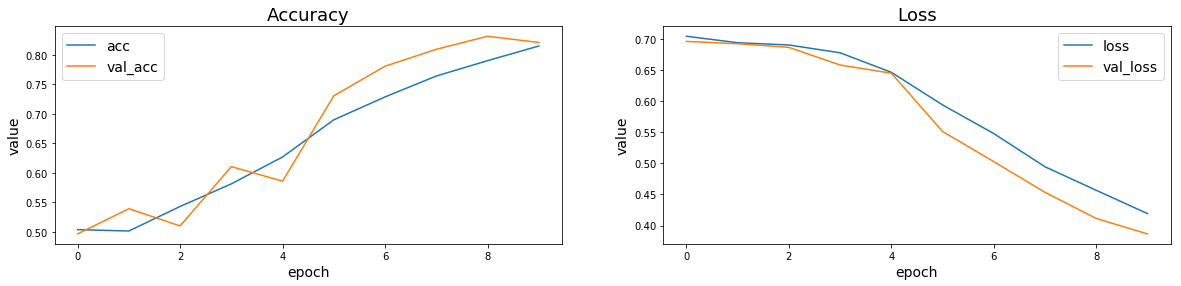

----------------------
2487/2487 [==============================] - 15s     

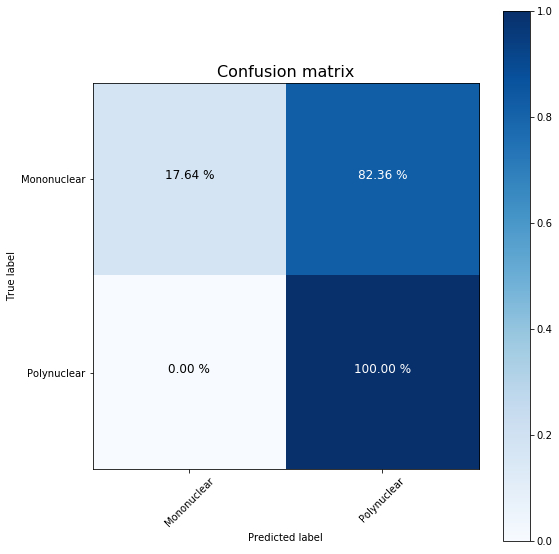

CPU times: user 1min 9s, sys: 20.1 s, total: 1min 29s
Wall time: 31 s


In [16]:
%%time
show_results(model=model2_1, 
                 history=history2_1,
                 X_test=X_test,
                 y_true_hot_enc=z_test_hot_enc,
                 dict_categories=dict_sub_categories)

#### * Test for a  multi-class problem *

In [17]:
%%time
NUM_CLASSES = 4
BATCH_SIZE = 32
MAX_EPOCHS = 15

model2_2 = my_model2(num_classes=NUM_CLASSES)
model2_2.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])

history2_2 = model2_2.fit_generator(datagen.flow(X_tr, y_tr, batch_size=BATCH_SIZE, shuffle=True),
                                steps_per_epoch=len(X_tr) / BATCH_SIZE, 
                                epochs=MAX_EPOCHS,
                                validation_data=(X_val, y_val))

Epoch 1/15
249/248 [==============================] - 144s - loss: 1.3927 - acc: 0.2444 - val_loss: 1.3866 - val_acc: 0.2410

#### * Plot and analyse the results *

----------------------
Model History
----------------------


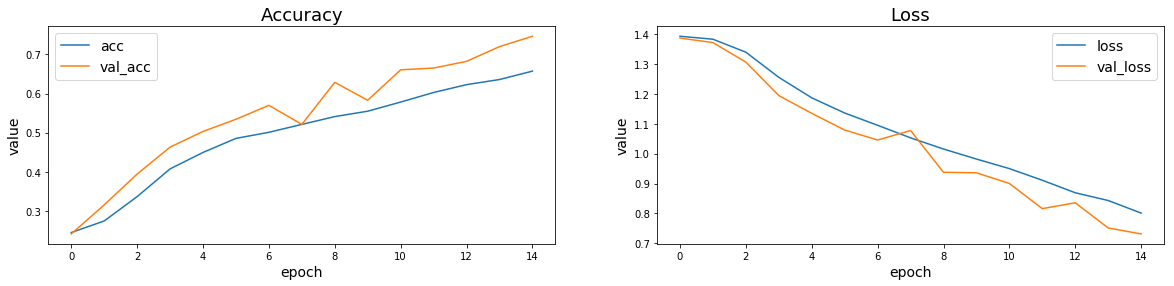

----------------------
2487/2487 [==============================] - 16s     

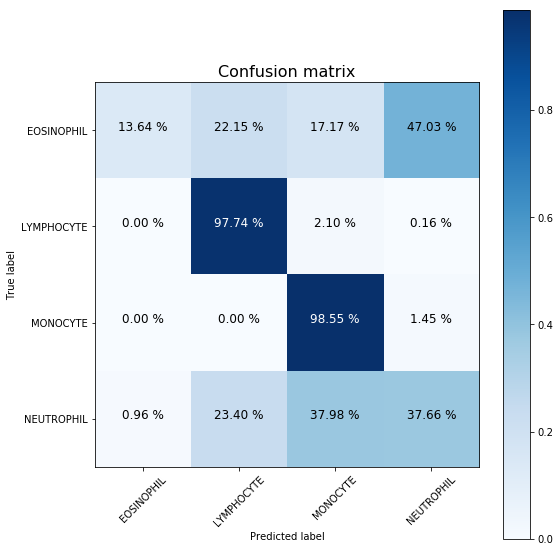

CPU times: user 1min 9s, sys: 21.1 s, total: 1min 30s
Wall time: 35 s


In [18]:
%%time
show_results(model=model2_2, 
                 history=history2_2,
                 X_test=X_test,
                 y_true_hot_enc=y_test_hot_enc,
                 dict_categories=dict_categories)